In [45]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from typing import List, Dict, Optional
from datetime import timedelta
from collections.abc import Mapping


class PerformanceDashboard:
    """
    Visualize inference performance metrics grouped by supervoxel_type.
    - Line plots: inference_time_sec, cache_hit_ratio_percent (mean ± std).
    - Table: runtime duration and number of samples (mean ± std).
    Filters out runs with group == "ABPC".
    """

    def __init__(
        self,
        entity: str = "giuliosichili",
        project: str = "automi",
        group_key: str = "group",
        supervoxel_key: str = "supervoxel_type",
        excluded_group: str = "ABPC",
        page_size: int = 256,
    ):
        self.entity = entity
        self.project = project
        self.page_size = page_size
        self.group_key = group_key
        self.supervoxel_key = supervoxel_key
        self.excluded_group = excluded_group
        self._api = wandb.Api()

    def run(self, supervoxel_type: str, save: bool = False, dpi: int = 300):
        runs = self._fetch_runs(supervoxel_type)
        if not runs:
            print(f"[warning] No runs found for supervoxel_type='{supervoxel_type}'")
            return

        metrics = self._collect_metrics(runs)
        fig = self._plot(metrics, supervoxel_type)

        if save:
            fname = f"performance_dashboard_{supervoxel_type.replace(' ', '_')}.png"
            fig.savefig(fname, dpi=dpi, bbox_inches="tight")
            print(f"[saved] {fname}")

        plt.show()

    def _fetch_runs(self, supervoxel_type: str) -> List[wandb.apis.public.Run]:
        path = f"{self.entity}/{self.project}"
        filters = {
            f"config.{self.supervoxel_key}": {"$eq": supervoxel_type},
            f"config.{self.group_key}": {"$ne": self.excluded_group},
        }
        return list(self._api.runs(path, filters=filters))

    def _collect_metrics(self, runs: List[wandb.apis.public.Run]) -> Dict:
        # Ora salviamo (steps, values) per ogni run, non solo i valori senza indice.
        curves = {"inference_time_sec": [], "cache_hit_ratio_percent": []}
        scalars = {"runtime_sec": [], "n_samples": []}

        for r in runs:
            per_run_series = {k: {} for k in curves}

            try:
                history = r.history(keys=list(curves), pandas=False)
                for row in history:
                    step = row.get("_step", row.get("step"))
                    if step is None:
                        continue
                    for key in curves:
                        val = row.get(key, None)
                        if val is not None:
                            per_run_series[key][int(step)] = float(val)
            except Exception as e:
                print(f"[warning] Failed to read history from run {r.id}: {e}")

            for key in curves:
                if len(per_run_series[key]) == 0:
                    print(f"[warning] No usable history for {key} in run {r.id}")
                    continue
                steps_sorted = np.array(sorted(per_run_series[key].keys()), dtype=int)
                values_sorted = np.array([per_run_series[key][s] for s in steps_sorted], dtype=float)
                curves[key].append({"steps": steps_sorted, "values": values_sorted})

            # scalari dal summary
            try:
                total_sec = float(r.summary.get("_runtime", np.nan))
                if not np.isnan(total_sec):
                    scalars["runtime_sec"].append(total_sec)
            except Exception:
                pass

            # n_samples: ora dalla config (con fallback)
            n_samples = self._get_n_samples(r)
            if not np.isnan(n_samples):
                scalars["n_samples"].append(n_samples)
            else:
                print(f"[info] n_samples non trovato in config/summary/history per run {r.id}")

        return {"curves": curves, "scalars": scalars}

    def _plot(self, data: Dict, supervoxel_type: str):
        curves = data["curves"]
        scalars = data["scalars"]
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Helper: aggrega su un asse dei passi condiviso (unione dei passi di tutti i run)
        def aggregate_over_steps(series_list):
            # series_list: List[{"steps": np.array, "values": np.array}]
            # Unione dei passi
            all_steps = sorted(set(int(s) for d in series_list for s in d["steps"]))
            if len(all_steps) == 0:
                return np.array([]), np.array([]), np.array([])
            step_to_idx = {s: i for i, s in enumerate(all_steps)}

            M = np.full((len(series_list), len(all_steps)), np.nan, dtype=float)
            for i, d in enumerate(series_list):
                for s, v in zip(d["steps"], d["values"]):
                    j = step_to_idx[int(s)]
                    M[i, j] = v

            mu = np.nanmean(M, axis=0)
            # nanstd con ddof=1 -> NaN se count<2; sostituiamo con 0
            with np.errstate(invalid="ignore"):
                sd = np.nanstd(M, axis=0, ddof=1)
            sd = np.where(np.isnan(sd), 0.0, sd)
            return np.array(all_steps, dtype=int), mu, sd

        for ax, key, label in zip(
            axes,
            ["inference_time_sec", "cache_hit_ratio_percent"],
            ["Inference Time (s)", "Cache Hit Ratio (%)"],
        ):
            series_list = curves[key]
            if len(series_list) == 0:
                ax.set_visible(False)
                continue

            x, mu, sd = aggregate_over_steps(series_list)
            ax.plot(x, mu, lw=2.0, label=label)
            ax.fill_between(x, mu - sd, mu + sd, alpha=0.2)
            ax.set_title(key)
            ax.set_xlabel("Step")
            ax.set_ylabel(label)
            ax.grid(True)

        # Tabella con runtime e n_samples + global avg of time/hits
        rt = np.array(scalars["runtime_sec"])
        ns = np.array(scalars["n_samples"])
        rt_mu = np.nanmean(rt) if rt.size else np.nan
        rt_sd = np.nanstd(rt, ddof=1) if rt.size > 1 else (0.0 if rt.size == 1 else np.nan)
        ns_mu = np.nanmean(ns) if ns.size else np.nan
        ns_sd = np.nanstd(ns, ddof=1) if ns.size > 1 else (0.0 if ns.size == 1 else np.nan)

        # Compute scalar global averages across runs for time and hits
        def _aggregate_scalar(series_list):
            vals = []
            for d in series_list:
                v = np.nanmean(np.array(d.get("values", []), dtype=float)) if len(d.get("values", [])) > 0 else np.nan
                vals.append(v)
            arr = np.array(vals, dtype=float)
            mu = np.nanmean(arr) if arr.size else np.nan
            sd = np.nanstd(arr, ddof=1) if arr.size > 1 else (0.0 if arr.size == 1 else np.nan)
            return mu, sd

        it_mu, it_sd = _aggregate_scalar(curves["inference_time_sec"])
        ch_mu, ch_sd = _aggregate_scalar(curves["cache_hit_ratio_percent"])

        def fmt_seconds(seconds: float) -> str:
            if seconds is None or np.isnan(seconds):
                return "–"
            td = timedelta(seconds=int(seconds))
            h, remainder = divmod(td.seconds, 3600)
            m, s = divmod(remainder, 60)
            h += td.days * 24
            return f"{h}h {m}m {s}s"

        table_ax = fig.add_axes([0.25, -0.35, 0.5, 0.3])
        table_ax.axis("off")
        table_ax.table(
            cellText=[
                [fmt_seconds(rt_mu), f"± {fmt_seconds(rt_sd)}"],
                [f"{ns_mu:.1f}" if not np.isnan(ns_mu) else "–", f"± {ns_sd:.1f}" if not np.isnan(ns_sd) else "–"],
                [f"{it_mu:.2f} s" if not np.isnan(it_mu) else "–", f"± {it_sd:.2f} s" if not np.isnan(it_sd) else "–"],
                [f"{ch_mu:.1f} %" if not np.isnan(ch_mu) else "–", f"± {ch_sd:.1f} %" if not np.isnan(ch_sd) else "–"],
            ],
            rowLabels=["Runtime", "#Samples", "Avg Inference Time (s)", "Avg Cache Hit (%)"],
            colLabels=["Mean", "Std Dev"],
            cellLoc="center",
            loc="center",
        ).scale(1.2, 1.2)

        fig.suptitle(f"Inference Performance — SV: {supervoxel_type}", fontsize=14)
        fig.tight_layout(rect=[0, 0.08, 1, 1])
        return fig
    
    def _get_n_samples(self, r: wandb.apis.public.Run) -> float:
        """
        Cerca n_samples in ordine: config (anche annidata) -> summary -> history.
        Ritorna np.nan se non trovato.
        """
        candidate_keys = ["n_samples", "num_samples", "n_total", "dataset_size"]

        def deep_find(d: Mapping) -> Optional[float]:
            for k, v in d.items():
                if k in candidate_keys and isinstance(v, (int, float)):
                    return float(v)
                if isinstance(v, Mapping):
                    found = deep_find(v)
                    if found is not None:
                        return found
                elif isinstance(v, list):
                    for it in v:
                        if isinstance(it, Mapping):
                            found = deep_find(it)
                            if found is not None:
                                return found
            return None

        # 1) CONFIG
        try:
            conf = dict(r.config)  # DotDict -> dict
            val = deep_find(conf)
            if val is not None:
                return val
        except Exception:
            pass

        # 2) SUMMARY (fallback)
        for k in candidate_keys:
            try:
                v = r.summary.get(k, None)
                if v is not None:
                    return float(v)
            except Exception:
                continue

        # 3) HISTORY (fallback: prima occorrenza)
        try:
            for row in r.history(keys=candidate_keys, pandas=False):
                for k in candidate_keys:
                    v = row.get(k, None)
                    if v is not None:
                        return float(v)
        except Exception:
            pass

        return np.nan

/var/folders/7p/yjn93vy92vs94f3hdj934z3w0000gn/T/ipykernel_15537/2759608960.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.08, 1, 1])


[saved] performance_dashboard_full-organs.png


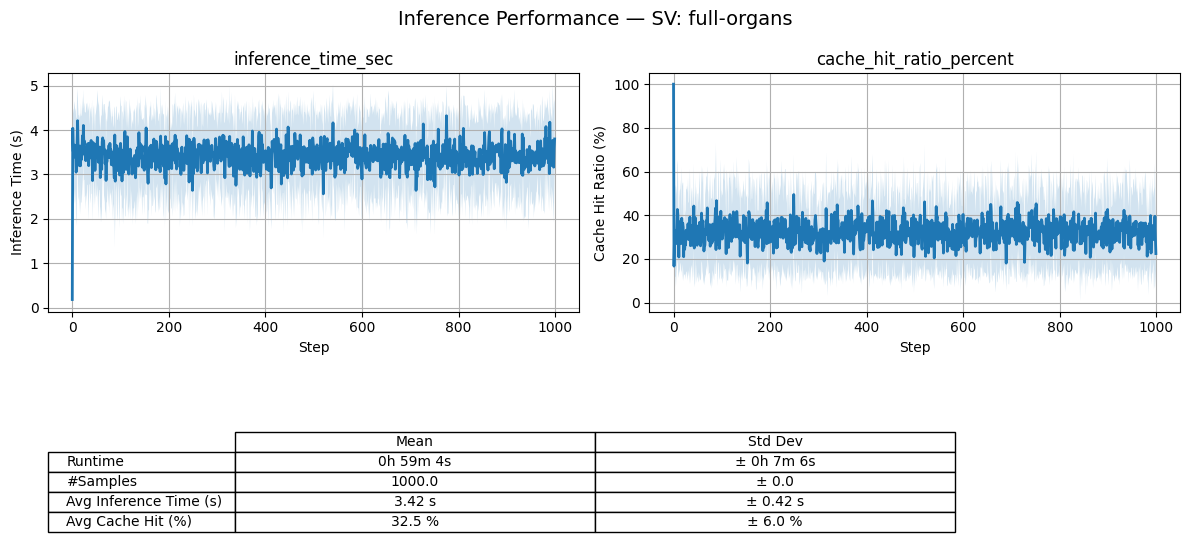

In [54]:
dash = PerformanceDashboard()
dash.run(supervoxel_type="full-organs", save=True)

/var/folders/7p/yjn93vy92vs94f3hdj934z3w0000gn/T/ipykernel_15537/2759608960.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.08, 1, 1])


[saved] performance_dashboard_FCC-organs.png


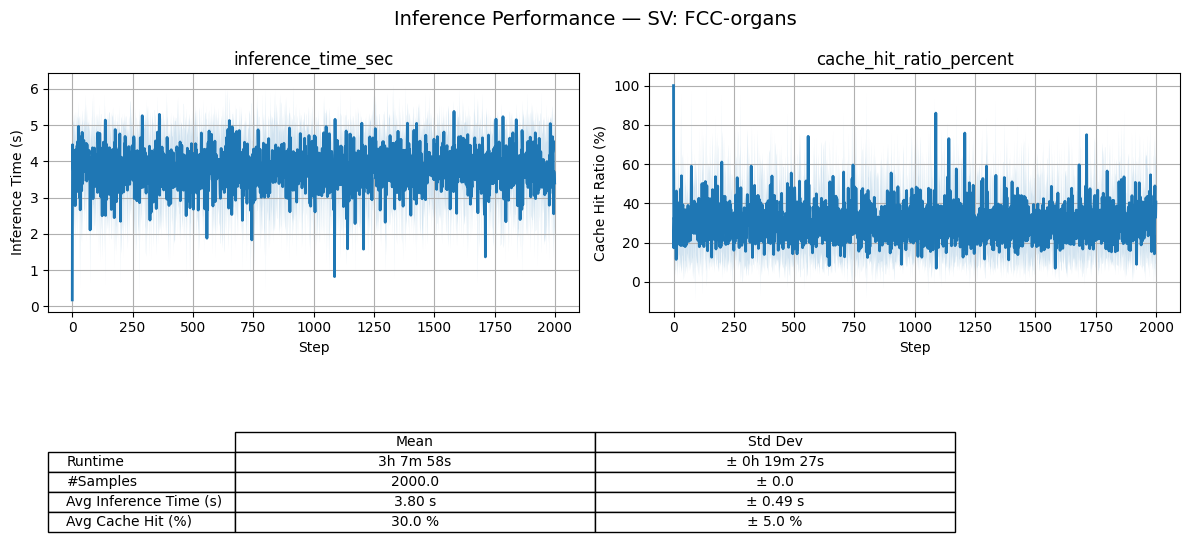

In [53]:
dash = PerformanceDashboard()
dash.run(supervoxel_type="FCC-organs", save=True)

/var/folders/7p/yjn93vy92vs94f3hdj934z3w0000gn/T/ipykernel_15537/2759608960.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.08, 1, 1])


[saved] performance_dashboard_FCC.png


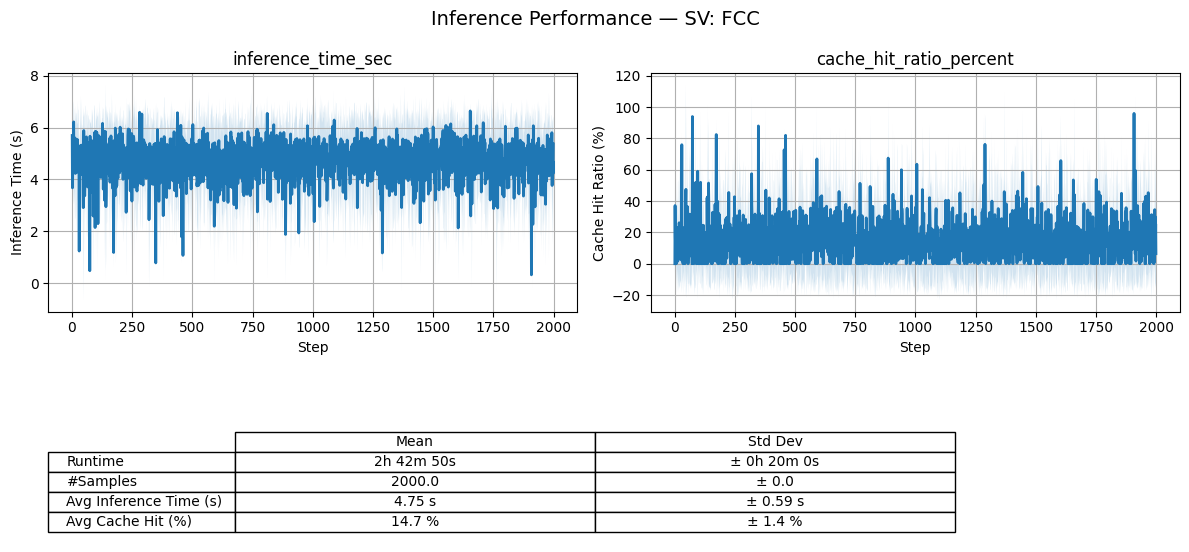

In [51]:
dash = PerformanceDashboard()
dash.run(supervoxel_type="FCC", save=True)

In [ ]:
"""api = wandb.Api()
run = api.run("giuliosichili/automi/jzli62c8")
print(run.summary.keys())
print(run.history(keys=["inference_time_sec", "cache_hit_ratio_percent"]))"""

dict_keys(['_runtime', '_step', '_timestamp', '_wandb', 'cache_hit_ratio_percent', 'inference_time_sec'])
     _step  inference_time_sec  cache_hit_ratio_percent
0        1            3.324947                    12.50
1        4            3.055896                    20.00
2        6            3.345663                    12.50
3        9            1.668935                    58.75
4       12            3.366526                    12.50
..     ...                 ...                      ...
495    991            2.506558                    37.50
496    992            3.410350                    12.50
497    993            3.411120                    12.50
498    996            3.131220                    20.00
499    999            0.985129                    77.50

[500 rows x 3 columns]
